<a href="https://colab.research.google.com/github/Jeongmin-heo/Business-Analytics/blob/master/BA_week2_assignment_news_social_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 크롤링

## 1.1 크롤링을 위한 준비

- 뉴스에 대한 분석을 위하여 데이터를 수집하도록 하겠습니다. 
- 데이터의 출처는 네이버 자주 보는 뉴스를 참고하여 1년간의 데이터를 수집하였습니다. 

In [1]:
import requests
from urllib.parse import urlparse, parse_qs
import pandas as pd
from bs4 import BeautifulSoup
import os
from pathlib import Path
import glob
import datetime

In [2]:
start_date = datetime.datetime(2019, 9, 18, 3, 22, 32) #오늘로 부터 1년간

In [3]:
# date를 가져오는 함수 
def get_date_string(start_date, period=365):
    # 20190721 형태의 Date String List 생성
    return [
        (start_date + datetime.timedelta(days=day)).strftime("%Y%m%d")
        for day in range(period)
    ]

In [4]:
date_string_list = get_date_string(start_date, 366)
date_string_list[0], date_string_list[-1] # 생성 완료

('20190918', '20200917')

## 1.2 네이버 많이 본 뉴스 목록 크롤링

In [5]:
# 6가지 섹션에 대한 TOP5 목록 가져오기
def get_top_news(date): 
    # 많이 본 뉴스 페이지 링크
    url = f"https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&date={date}" 
    res = requests.get(url)
    soup = BeautifulSoup(res.text, "html.parser")
    
    result = []
    # 6가지 섹션에 대해서만 진행
    for section in soup.select('.content .content .ranking_section')[:6]:
        for news in section.select('li'):
            result.append(
                    [
                        # 뉴스의 섹션 정보 ex) '정치'
                        news.parent.parent.select_one('h4').text.strip(),
                        # TOP5에 선정된 날짜
                        date,
                        # 뉴스의 제목 
                        news.select_one('dt a')['title'],
                        # 뉴스의 링크 (news.naver.com을 추가한 링크)
                        'https://news.naver.com' + news.select_one('dt a')['href'],
                        # 뉴스를 작성한 신문사 명 :not(.lede
                        news.select_one('span').text.strip(),
                        # 뉴스 조회수
                        news.select_one('.count_view').text
                    ]
            )
    return result

In [6]:
news_data = []
# 2019.09.18 ~ 2020.09.17
for date in date_string_list:
    news_data.extend(get_top_news(date))

In [7]:
print(len(news_data))
news_data[:3] # 결과 예시

10980


[['정치',
  '20190918',
  '"표창장 위조 사실땐 나도 조국반대" 이랬던 여권 인사들 곤혹',
  'https://news.naver.com/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=025&aid=0002937981&date=20190918&type=2&rankingSectionId=100&rankingSeq=1',
  '조국 법무부 장관을 변호하던 여권 인사들이 줄줄이 곤궁한 처지가 되고 있다. 조국 장관의 해명을 믿고 적극 옹호했는데, 그…',
  '245,913'],
 ['정치',
  '20190918',
  '[단독] 유은혜·김현미·진영·박영선 내년 총선 불출마',
  'https://news.naver.com/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=025&aid=0002937808&date=20190918&type=1&rankingSectionId=100&rankingSeq=2',
  '중앙일보',
  '213,632'],
 ['정치',
  '20190918',
  '"조국 사퇴하라" 한국당, 릴레이 삭발…나경원 삭발 언제하나',
  'https://news.naver.com/main/ranking/read.nhn?mid=etc&sid1=111&rankingType=popular_day&oid=277&aid=0004538064&date=20190918&type=1&rankingSectionId=100&rankingSeq=3',
  '아시아경제',
  '179,977']]

In [8]:
# 결과물을 데이터 프레임으로 변환 및 Column Name 부여
df_top_news = pd.DataFrame(news_data, 
                           columns=["section", "TOP_date", "title", "url", "press", "views"])
df_top_news.tail(3)

,section,TOP_date,title,url,press,views
10977,IT/과학,20200917,회사 단톡방서 해방?…'업무용 카톡' 나오자마자 써봤습니다,https://news.naver.com/main/ranking/read.nhn?m...,한국경제,"152,428"
10978,IT/과학,20200917,"""가족들 다 보는데 성추행 연상 방송""…지상파 일탈에 '법정제재'",https://news.naver.com/main/ranking/read.nhn?m...,머니투데이,"141,692"
10979,IT/과학,20200917,"""카톡은 사생활에만 쓰세요""…업무용 카톡 나왔다(종합)",https://news.naver.com/main/ranking/read.nhn?m...,머니투데이,"118,938"


In [9]:
df_top_news.to_csv("df_top_news.csv",encoding='utf-8-sig') #저장

# 2. 저장후 뉴스 제목만 따로 추출

## 2.1 불러오기 및 Hannanum 설치
- 뉴스 제목만 따로 추출하여 그중에서도 제가 관심 있는 '제주' 키워드가 들어간 뉴스만 따로 추출하여 진행하도록 하겠습니다.

In [10]:
import numpy as np
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
f = open('txt.txt','r',encoding='UTF-8')
lines = f.readlines()
f.close

<function TextIOWrapper.close>

In [12]:
!pip install konlpy
from konlpy.tag import Hannanum
hannanum = Hannanum()

## 2.2 단어 단위 추출, 불필요한 내용 제거

In [13]:
dataset = []
for i in range(len(lines)):
  dataset.append(hannanum.nouns(re.sub('[^가-힣a-zA-Z\s]','',lines[i])))
dataset

[['포토', '착륙', '여행', '관심'],
 ['이재명', '임대료', '감면', '유권해석', '행정지도', '정부', '건의'],
 ['수도권', '유', '초', '중', '고교생', '내일', '학교'],
 ['수도권', '유', '초', '중', '학생들', '일', '학교'],
 ['만장', '중', '보석'],
 ['김해', '공항', '시니어', '공항서포터즈', '노인일자리'],
 ['코', '이후', '첫', '국제관광교류', '대만인', '착륙', '제주', '상공여행'],
 ['강원', '지', '중부', '내륙', '아침기온', '도', '완연', '가을'],
 ['제주', '방역', '안전국간', '관광마케팅', '강화'],
 ['연안여객선', '현대화펀드', '제호', '퀸', '누비아호', '첫', '출항'],
 ['추석연휴', '제주', '관광객', '공항', '발열', '때', '강제검사', '자부담', '격리'],
 ['한국', '대만관광객', '명', '제주상공', '여행'],
 ['박주희', '진품명품', '장원', '등극', '예리', '폭발', '역사', '관심'],
 ['제주', '해운대', '호텔', '만', '서울', '호텔', '썰렁'],
 ['코', '중환자', '명', '수도권', '즉시가용', '병상', '개'],
 ['제회', 'SW사고력올림피아드', '온라인', '성공', '개최', '코', '시대', '경진대회', '해법', '제시'],
 ['제주조릿대', '효과적', '관리', '도민', '해법찾기'],
 ['고유정', '커튼머리', '여성', '피고', '들', '유행'],
 ['제주연근해', '참조', '풍년'],
 ['한라산', '친환경', '화장실', '청결', '만족'],
 ['가능성', '경제', '제주', '공유'],
 ['영상', '제주특별자치', '교육청뉴스', '월주차'],
 ['최대집', '의협', '회장', '탄핵', '여부', '일', '결판'],
 ['날씨', '전국',

## 2.3 Apriori 알고리즘을 확인하여 연관규칙 분석 수행
- 항목의 개수가 2개이고 지지도가 0.01 이상인 항목만 추출

In [14]:
#!pip install apriori
#!pip install apyori
from apyori import apriori
result = (list(apriori(dataset, min_support = 0.01)))

df=pd.DataFrame(result)
df['length'] = df['items'].apply(lambda x: len(x))
df = df[(df['length']==2) &
        (df['support'] >= 0.001)].sort_values(by='support', ascending = False)

df.head()

,items,support,ordered_statistics,length
80,"(태풍, 바비)",0.030423,"[((), (태풍, 바비), 0.03042261964232191, 1.0), ((바...",2
92,"(태풍, 제주)",0.027625,"[((), (태풍, 제주), 0.027625137376361276, 1.0), ((...",2
73,"(태풍, 마이삭)",0.026526,"[((), (태풍, 마이삭), 0.026526126486162455, 1.0), (...",2
76,"(명, 코)",0.023279,"[((), (명, 코), 0.023279048856029574, 1.0), ((명)...",2
62,"(비, 날씨)",0.021730,"[((), (비, 날씨), 0.021730442601658507, 1.0), ((날...",2


## 2.4 네트워크 그리기

In [15]:
G = nx.Graph()
ar = (df['items']); G.add_edges_from(ar)

In [16]:
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

In [17]:
pos = nx.planar_layout(G)

In [18]:
!sudo apt-get install -y fonts-nanum #폰트 설치
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


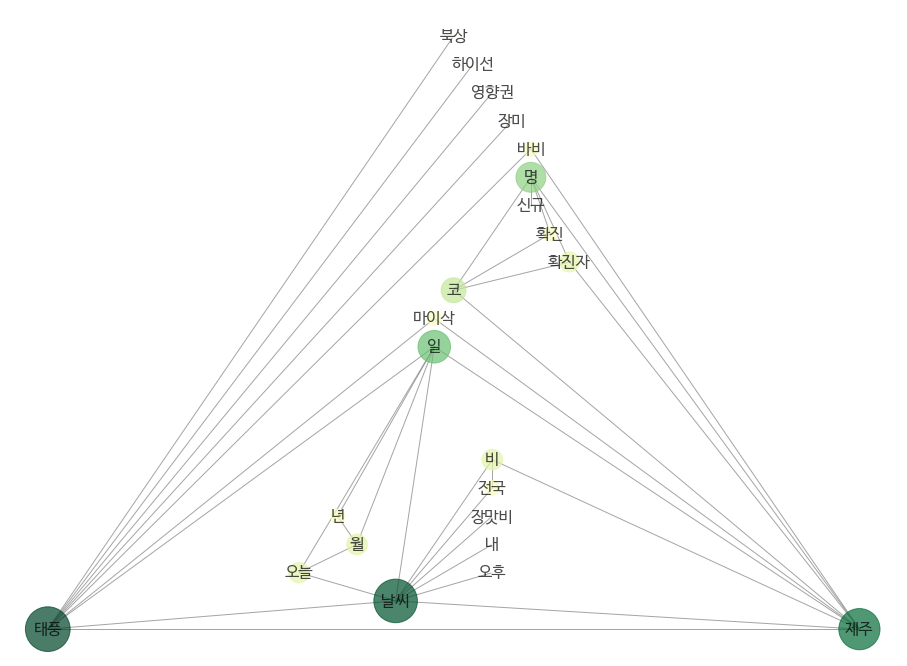

In [19]:
plt.figure(figsize = (16,12))
plt.axis('off')

nx.draw_networkx(G, font_family = 'NanumBarunGothic', font_size = 16,
                 pos=pos, node_color=list(pr.values()), node_size=nsize,
                 alpha = 0.7, edge_color='.5', cmap=plt.cm.YlGn)

plt.savefig('test.png', bbox_inches = 'tight')